# Introduction to PyTorch

In this assignment, we will use PyTorch, one of the most popular deep learning libraries out there. Similarly to programming languages, deep learning libraries can be very different in terms of syntax, yet they all revolve around the same concepts, so once you master one, learning another is much less challenging. We also use `seaborn` to plot charts and `scikit-learn` to download datasets. The three cells below should install, respectively:
1. PyTorch: `torch` and `torchvision`, version at least `1.13` (2022/23 remark: version 1.13 is the most recent stable version and we use one freshly added feature)
2. Seaborn
3. `scikit-learn` version at least `0.23`.

In [1]:
# !pip install torch>=1.13 torchvision --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
# !pip install seaborn

In [3]:
# !pip install scikit-learn>=0.23.0

# Linear regression

## Data preparation

For this task we'll consider the problem of predicting houses prices in California. We begin by loading the dataset using `fetch_california_housing`. The returned object contains a few fields:

* `data` - the matrix of features
* `feature_names` - names of the features
* `target` - the values to predict

In [4]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

Let's see its description:

In [5]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Now we convert the data to `torch.Tensor`, a PyTorch-specific representation of a tensor (a tensor is a generalization of a matrix to more than 2 dimensions). The `dtype` parameter forces conversion to floating-point numbers. The output of the cell is the size of the matrices. The output of the cell are the shapes of both tensors - `X` is 20640 rows by 8 columns and `y` is a vector of 20640 values

In [6]:
import torch

X = torch.tensor(dataset['data'], dtype=torch.float)
y = torch.tensor(dataset['target'], dtype=torch.float)

X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640]))

We then split the data randomly into three subsets: a training set consisting of 70\% of the learning examples, a validation set consisting of 10\% and a test set consisting of the remaining 20\%.

In [7]:
import torch.utils.data as data
training, validation, test = data.random_split(data.TensorDataset(X, y), [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 14448
Validation: 2064
Test: 4128


Let's inspect the first element of the training set - it is a pair of tensors, the first one consisting of 8 values (the features), whereas the second one is a tensor of a single value (the target)

In [8]:
training[0]

(tensor([ 5.6063e+00,  1.6000e+01,  6.4174e+00,  9.6957e-01,  1.5250e+03,
          3.3152e+00,  3.7450e+01, -1.2190e+02]),
 tensor(3.2050))

## Building a simple regressor

PyTorch is based on modules (objects of the class `torch.nn.Module`), which are composed into a compution graph. Each module may use parameters (objects of the class `torch.nn.Parameter`), and for each such an object it is possible to automatically compute gradients and optimize them according to some cost function.

We begin by constructing a single linear layer, that is, a layer implementing the operation $\hat{y} = Xw + b$

In [9]:
import torch.nn as nn

regressor = nn.Linear(8, 1) # 8 input features, 1 output feature

To evaluate the performance we use mean-squared error. While PyTorch offers a ready to use implementation as the class `torch.nn.MSELoss()`, this time we implement it manually as an example. The main point is to inherit from the class `torch.nn.Module` and then to override the method `forward`, which is responsible for performing computations in the forward direction of the computation graph. Computations in the backward direction (that is, gradient flow) are derrived automatically.

In [10]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

We would like to optimize the vector `w` and `b` automatically during the learning. To this end, we use the class `torch.optim.Adam`, which implements some extensions of the graident descent algorithm. We construct the object `opt`, which is responsible for optimizing the regressor's parameters, obtained by calling `regressor.parameters()`.

In [11]:
import torch.optim as optim

opt = optim.Adam(regressor.parameters())

## Starting computations

We implement mini-batch learning over `n_epoch` epochs. Within each epoch:
1. We shuffle the training set and iterate over it in the batches of `batch_size` examples
3. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
4. We execute the regressor and compute the mean-squared error (MSE).
5. We compute the gradients (`mse_value.backward()`) and apply them (`opt.step()`) to update the parameters of the regressor
6. We store the value of MSE. We call the `detach()` method to detach the MSE from its gradients. This enables passing the values to other libraries like `seaborn`.

After an epoch is completed, we average the collected MSEs and store the value.

In [12]:
import numpy as np

mse_values = []
batch_size = 100
n_epoch = 10
for epoch in range(n_epoch):    
    mse_epoch = []
    for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):        
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.item())
    mse_values.append(np.mean(mse_epoch))    

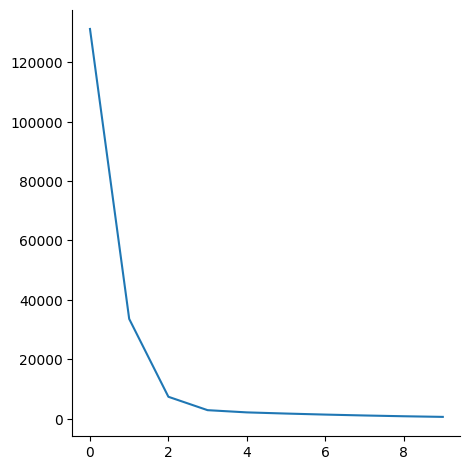

In [13]:
import seaborn as sns

_ = sns.relplot(x=range(len(mse_values)), y=mse_values, kind="line")

Execute the two preceeding cells of the code again. Because the regressor and the optimizer were not created anew, so the parameters are already optimized and the obtained charts are vastly different. In order to return to the initial state it is necessary to create new obiect `regressor` and `opt`.

## Task 1: Early stopping

Complete the function `train_linear_regression` implementing the early stopping: after each epoch of learning compute the value of MSE using the sets `X_validation` and `y_validation`. Keep track of the epoch number you got the best value of the MSE on the validation set so far. Stop the learning process if that epoch is at least `no_improvment` epochs in the past. Store MSE for validation in the `validation_mses` list and return it along with the trained regressor.

Hints and remarks:
* Observe that we must call the methods `regressor.train()` and `regressor.eval()` to switch the module between the training mode and the evaluation mode. 
* Remeber not to call `opt.step()` after performing the computation on the validation set, to not update the weights of the model. Similarly, you don't need to compute gradients during this step.
* You don't need to shuffle the validation set, nor go over it using batches. Instead, you can access the underlying tensors: `validation[:][0]` gets you the X matrix, whereas `validation[:][1]` returns the y vector.
* You may want to print out the epoch number and the value of the MSE on the validation set every time you find a better value. In the beginning you should expect a better value more or less every epoch and the decrease in MSE will be step, with time the decreases will diminishi and you'll hit a better value only every few epochs

In [14]:
def train_linear_regression(training: data.Dataset, 
                            validation: data.Dataset, 
                            no_improvement: int = 10,
                            batch_size: int = 128,
                            max_epochs: int = 100_000):
                            
    n_features = training[0][0].shape[0]
    regressor = nn.Linear(n_features, 1) # n_features input features, 1 output feature
    opt = optim.Adam(regressor.parameters())

    training_mses = []
    validation_mses = []
    noImprov = 0
    bestMSE = float('inf')
    for epoch in range(max_epochs):
        regressor.train()
        mse_epoch = []
        for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            mse_value = mse(y_pred, y_batch)
            mse_value.backward()
            opt.step()
            mse_epoch.append(mse_value.item())
        training_mses.append(np.mean(mse_epoch))

        
        regressor.eval()
        y_pred = regressor(validation[:][0]).reshape((-1,))
        mse_value = mse(y_pred, validation[:][1])
        validation_mses.append(mse_value.item())
        if mse_value.item() <= bestMSE:
            bestMSE = mse_value.item()
            noImprov = 0
            print(mse_value.item(), epoch)
        else:
            noImprov += 1

        if noImprov == no_improvement:
            break
        


    return regressor, validation_mses

Let's test your solution. First, we train the regressor.

In [15]:
regressor, validation_mses = train_linear_regression(training, validation)

165364.671875 0
61785.046875 1
18968.021484375 2
4692.34912109375 3
935.046875 4
193.0972442626953 5
73.37699890136719 6
56.11195373535156 7
51.61139678955078 8
48.18628692626953 9
44.991397857666016 10
41.669185638427734 11
38.692176818847656 12
35.85220718383789 13
33.24895095825195 14
30.952083587646484 15
28.928077697753906 16
26.964500427246094 17
25.12738037109375 18
23.55547332763672 19
22.034027099609375 20
20.818334579467773 21
19.51598358154297 22
18.407865524291992 23
17.33561134338379 24
16.407573699951172 25
15.517634391784668 26
14.648140907287598 27
13.851907730102539 28
13.507118225097656 29
12.463895797729492 30
11.62432861328125 31
10.949328422546387 32
10.700427055358887 33
9.574291229248047 34
9.00432300567627 35
8.489779472351074 36
7.898649215698242 37
7.40949010848999 38
6.878798961639404 39
6.4375224113464355 40
5.966861248016357 41
5.552516937255859 42
5.169464111328125 43
4.804507255554199 44
4.449403762817383 45
4.132607936859131 46
3.823298931121826 47
3.562

We plot the last 40 values of MSE on the validation set. If you implemented the early stopping correctly, the lowest value should be exactly at 30 (`=40-no_imporvement`)

166
[0.6243705153465271, 0.6414018869400024, 0.6688141226768494, 0.6601675152778625, 0.6161960959434509, 0.6156669855117798, 0.7559383511543274, 0.6116989850997925, 0.6256651878356934, 0.6337442994117737, 0.6105169653892517, 0.6770641207695007, 0.6805270910263062, 0.6089953780174255, 0.6224454045295715, 0.6008796691894531, 0.6063406467437744, 0.6083196997642517, 0.6439139246940613, 0.5988727807998657, 0.6077786087989807, 0.5945106148719788, 0.611847460269928, 0.6008917093276978, 0.5980493426322937, 0.6037484407424927, 0.7706555724143982, 0.6573507189750671, 0.6095491051673889, 0.5917501449584961, 0.6993164420127869, 0.6244196891784668, 0.6051650047302246, 0.8022089004516602, 0.5952343940734863, 0.6446914076805115, 0.6097884774208069, 0.6057510375976562, 0.6428278088569641, 0.6186537742614746]
0.5917501449584961 29


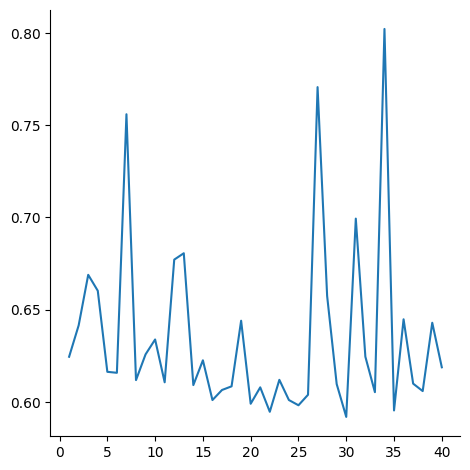

In [16]:
print(len(validation_mses))
print(validation_mses[-40:])
print(min(validation_mses[-40:]), validation_mses[-40:].index(min(validation_mses[-40:])))
_ = sns.relplot(x=range(1, 41), y=validation_mses[-40:], kind="line")


Finally, let's compute the mse on the test set. It should be similar to those we got on the validation set.

In [17]:
regressor.eval()
y_pred = regressor(test[:][0]).reshape((-1,))
print("MSE on the test set:", mse(y_pred, test[:][1]).item())

MSE on the test set: 0.6353560090065002


# Classification

The second part is concerned with the classification task. We begin by downloading the MNIST dataset, consisting of 70.000 examples of handwritten digits (0-9), represented as grayscale images of 28x28 pixels. We use the function `fetch_openml` that downloads the data from [https://www.openml.org/](https://www.openml.org).

In [18]:
from sklearn.datasets import fetch_openml
mnist_sklearn = fetch_openml('mnist_784', version=1, as_frame=False)

Let's learn something about the dataset

In [19]:
print(mnist_sklearn.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [20]:
X = torch.tensor(mnist_sklearn.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist_sklearn.target])
mnist = data.TensorDataset(X, y)
mnist_conv = data.TensorDataset(X.reshape((-1, 1, 28, 28)), y)

Lets inspect some examples. The digit in the top-right corner of each image is not a part of the image itself, but rather the label of the image, displayed using `ax.text` in the code below. For the visualisation we use `matplotlib`, a library underlying the `seaborn` library.

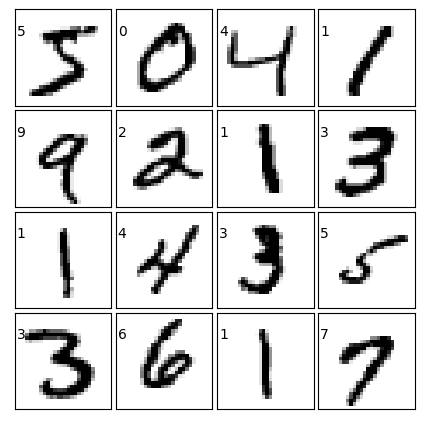

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (4,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(mnist[i][0].reshape(28, 28),cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(mnist[i][1].item()))

We again split the dataset into three subsets.

In [22]:
training, validation, test = data.random_split(mnist, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))
trainingConv, validationConv, testConv = data.random_split(mnist_conv, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 49000
Validation: 7000
Test: 14000


## Logistic regression

We create a simple logisitc regression model, learning on the raw pixels of the images. The matrix of the feature weights (here: pixels) is of the size $p \times k$, i.e., $p$ weights for each of the $k$ classes. The model computes logits, i.e., the output of the logistic  regression **before** applying the softmax function. In the output, each row corresponds to a single example and each column to a single class. Should each row be normalized using the softmax function, each row would be a probability distribution.

In [23]:
p = 28*28
k = 10
model = nn.Linear(p, k)

As the loss function we will use *cross entropy* and perform the optimization using the Adam optimizer. Observe that the optimizer gets the set of parameters to optimize. If you create a new model, you could reuse the old `loss_function`, but the optimizer must be created anew.

In [24]:
loss_function = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

We create an auxiliary function to compute the classification accuracy. For each row of the `logits` matrix we select the number of the column with the highest value and compare it with the expected (true) value. This way we obtain a vector of 0s and 1s, which are then averaged to compute the accuracy.

In [25]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

The remainder is very similar to the linear regression: we create a data loder (`torch.utils.data.DataLoader`)  to handle shuffling and creating batches for us, and then during each of the `n_epoch` epochs, we enable the training mode (`model.train()`), and then iterate over the loader, computing loss and gradients. Then we evaluate by computing the accuracy on the validation set.

In [26]:
loss_values = []
acc_values = []
batch_size = 512
n_epoch = 10

In [27]:
loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)    

for epoch in range(n_epoch):    
    model.train()    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        
        loss = loss_function(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(validation[:][0])
    acc = compute_acc(logits, validation[:][1]).item()
    print("Epoch:", epoch, "accuracy:", acc)
    acc_values.append(acc)

Epoch: 0 accuracy: 0.8697142601013184
Epoch: 1 accuracy: 0.876714289188385
Epoch: 2 accuracy: 0.8730000257492065
Epoch: 3 accuracy: 0.8862857222557068
Epoch: 4 accuracy: 0.8875714540481567
Epoch: 5 accuracy: 0.8898571133613586
Epoch: 6 accuracy: 0.8787142634391785
Epoch: 7 accuracy: 0.880142867565155
Epoch: 8 accuracy: 0.8817142844200134
Epoch: 9 accuracy: 0.8868571519851685


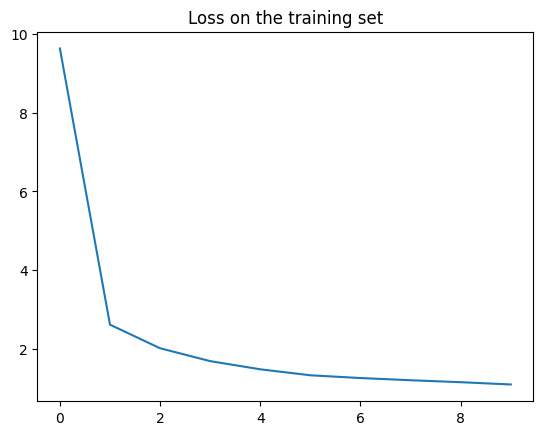

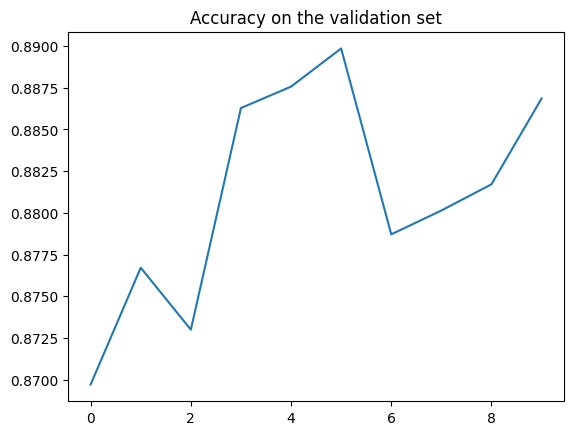

In [28]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

Observe that the first epoch already gets us very high and then the improvements are very small.

## Task 2: Learning framework

The function `train_classifier` below is supposed to be an integrated tool for fitting parameters of the given `model`. Complete the function below so that it:

* Trains `model` using the training set (`training`) for at most `max_epochs` using the mini-batches of the `batch_size` size
* Implements early stopping using the validation set (`validation`), stopping if there is no improvement on accuracy for `no_improvement` epochs
* Returns a list such that i-th element of this list is the accuracy on the validation set after the i-th epoch of training
* Use the cross-entropy loss and the Adam optimizer for training, but make sure you don't reuse the global objects `loss_function` and `opt`
* Remember to switch between the training mode (`model.train()`) and the evaluation mode (`model.eval()`)

In [29]:
def train_classifier(model: nn.Module,        
              training: data.Dataset, 
              validation: data.Dataset,
              no_improvement: int = 10,
              batch_size: int = 128,
              max_epochs: int = 100_000):
    n_features = training[0][0].shape[0]
    classifier = model
    loss_function = torch.nn.CrossEntropyLoss()
    opt = optim.Adam(classifier.parameters())

    training_losses = []
    validation_losses = []
    accs = []
    noImprov = 0
    bestACC = float('-inf')
    for epoch in range(max_epochs):
        classifier.train()
        epoch_loss = []
        for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):
            opt.zero_grad()
            logits = classifier(X_batch)
            loss = loss_function(logits, y_batch)
            loss.backward()
            opt.step()
            epoch_loss.append(loss.detach())
        training_losses.append(torch.tensor(epoch_loss).mean())

        classifier.eval()
        logits = classifier(validation[:][0])
        loss_value = loss_function(logits, validation[:][1])
        validation_losses.append(loss_value.item())
        acc = compute_acc(logits, validation[:][1]).item()
        accs.append(acc)

        if acc > bestACC:
            indexBest = epoch
            bestACC = acc
            noImprov = 0
            print(acc, epoch)
        else:
            noImprov += 1

        if noImprov >= no_improvement:
            break
    return accs

Test it by training logistic regression on the MNIST dataset and then plotting the accuracies. The best accuracy should be on the 10-th epoch from the end.

In [30]:
model = nn.Linear(28*28, 10)
accuracies = train_classifier(model, training, validation)

0.8577142953872681 0
0.8682857155799866 1
0.8924285769462585 2
0.8984285593032837 5


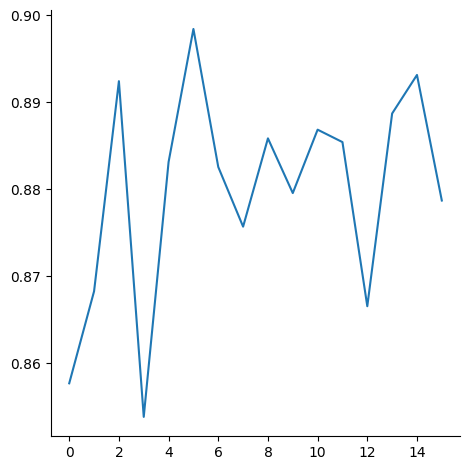

In [31]:
_ = sns.relplot(x=range(len(accuracies)), y=accuracies, kind="line")

## Task 3: A neural network with a hidden layer

Complete the cell below to create a neural network consisting of the following layers:
  1. Linear layer (`nn.Linear`) having `28*28` inputs and `300` outputs
  2. ReLU activation function (`nn.ReLU`)
  3. Dropout layer (`nn.Dropout`) with the probability of `0.5`
  4. Linear layer (`nn.Linear`) having `10` outputs
To combine layers into a single model use `nn.Sequential` 

If you haven't found it so far, the documentation for the `torch.nn` module may now be of use: [https://pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html)

In [32]:
model = nn.Sequential(nn.Linear(28*28, 300), nn.ReLU(), nn.Dropout(0.5), nn.Linear(300,10))

In [33]:
accuracies = train_classifier(model, training, validation)
print("The best accurac on the validation set:", max(accuracies))

0.9332857131958008 0
0.9462857246398926 1
0.9518571496009827 2
0.956428587436676 3
0.9589999914169312 5
0.9597142934799194 7
0.959857165813446 9
0.9635714292526245 10
0.9651428461074829 13
The best accurac on the validation set: 0.9651428461074829


## Task 4: Play with it!

Construct at least 6 substantially different models (use common sense - e.g., changing the number of neurons from 300 to 301 is not a substantial change). Make sure you not only consider different hyperparameters (e.g., changing the number of neurons, changing the activation function), but also different architectures (e.g., adding/removing a layer). Train them using `train_classifier` and evaluate them all on the test subset of MNIST using the accuracy measure. Print out these accuracies and indicate which model is the best.

If you want and can you can use other types of layers (e.g., convolutional layers), but please stick to what's available in PyTorch. The current state of the art on the MNIST dataset is around 99.9% accuracy [https://paperswithcode.com/sota/image-classification-on-mnist](https://paperswithcode.com/sota/image-classification-on-mnist).

In [34]:
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [35]:
# print(torch.version.cuda)
# print(torch.__version__)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.cuda.init()
# torch.cuda.get_arch_list()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(torch.cuda.is_available())

In [36]:

class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 64, 10)


    def forward(self, x):

        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)

        return x



class MultiLinearLayerNetWithDroupout(nn.Module):
    def __init__(self) -> None:
        super(MultiLinearLayerNetWithDroupout, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28*28, 420)
        self.fc2 = nn.Linear(420, 69)
        self.fc3 = nn.Linear(69, 30)
        self.fc4 = nn.Linear(30, 10)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.dropout(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.dropout(x)
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.dropout(x)
        x = self.dropout(x)
        x = F.softmax(x)
        x = self.fc4(x)

        
        return x



class MultiLinearLayerNetWithoutActivations(nn.Module):
    def __init__(self) -> None:
        super(MultiLinearLayerNetWithoutActivations, self).__init__()
        self.dropout = nn.AlphaDropout(0.5)
        self.fc1 = nn.Linear(28*28, 420)
        self.fc2 = nn.Linear(420, 69)
        self.fc3 = nn.Linear(69, 30)
        self.fc4 = nn.Linear(30, 10)


    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x



class MultiLinearWithBottleneck(nn.Module):
    def __init__(self) -> None:
        super(MultiLinearWithBottleneck, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(x)
        x = self.fc6(x)

        return x



class MultiLinearLayerNetWithoutDroupout(nn.Module):
    def __init__(self) -> None:
        super(MultiLinearLayerNetWithoutDroupout, self).__init__()
        self.fc1 = nn.Linear(28*28, 420)
        self.fc2 = nn.Linear(420, 69)
        self.fc3 = nn.Linear(69, 30)
        self.fc4 = nn.Linear(30, 10)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x



class DifferentActivationLinearLayerNet(nn.Module):
    def __init__(self, function) -> None:
        super(DifferentActivationLinearLayerNet, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        self.function = function

    def forward(self, x):
        x = self.function(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x



class MultiLinearLayerWithPowersOf2(nn.Module):
    def __init__(self) -> None:
        super(MultiLinearLayerWithPowersOf2, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        
        return x        

In [37]:
Score = {}

In [47]:
model = ConvNet()#.to(device)
accuracies = train_classifier(model, trainingConv, validationConv)
acc = compute_acc(model(testConv[:][0]), testConv[:][1]).item()
print("The best accuracy on the test set:", acc)
Score['CNN'] = acc
# torch.save(model.state_dict(), 'ConvNetWeights.pth')

0.9641428589820862 0
0.9778571724891663 1
0.9779999852180481 2
0.9782857298851013 3
0.9845714569091797 4
0.9847142696380615 14
0.9864285588264465 18
0.9869999885559082 27
The best accuracy on the test set: 0.9860000014305115


In [39]:
model = MultiLinearLayerNetWithoutDroupout()#.to(device)
accuracies = train_classifier(model, training, validation)
acc = compute_acc(model(test[:][0]), test[:][1]).item()
print("The accuracy on the test set:", acc)
Score['MLLND'] = acc
# torch.save(model.state_dict(), 'MultiLayerWeights.pth')

0.963857114315033 0
0.9668571352958679 2
0.9687142968177795 3
0.9691428542137146 4
0.9715714454650879 5
0.974142849445343 6
0.9762856960296631 9
0.9772857427597046 14
0.9774285554885864 17
0.9784285426139832 23
0.978857159614563 24
0.9791428446769714 28
0.9810000061988831 30
The accuracy on the test set: 0.9754999876022339


In [40]:
functions = [F.elu, F.selu, F.gelu, torch.tanh, torch.sigmoid, F.hardshrink, F.hardswish]
mem = float('-inf')
for fn in functions:
    model = DifferentActivationLinearLayerNet(fn)#.to(device)
    accuracies = train_classifier(model, training, validation)
    acc = compute_acc(model(test[:][0]), test[:][1]).item()
    print(fn, "The accuracy on the test set:", acc)
    if acc > mem:
        mem = acc
Score['DALLN'] = mem

0.9211428761482239 0
0.9422857165336609 1
0.9520000219345093 2
0.9548571705818176 4
0.9575714468955994 5
0.9577142596244812 6
0.9602857232093811 8
0.961571455001831 10
0.9641428589820862 11
0.9647142887115479 18
0.9667142629623413 23
0.9681428670883179 30
<function elu at 0x000001DF8342E4D0> The accuracy on the test set: 0.9628571271896362
0.9290000200271606 0
0.9435714483261108 1
0.946571409702301 2
0.9552857279777527 3
0.9557142853736877 5
0.9608571529388428 6
0.9629999995231628 10
0.9632856845855713 18
0.9639999866485596 19
0.9645714163780212 21
0.965571403503418 25
0.9658571481704712 27
0.9660000205039978 28
0.9682857394218445 33
<function selu at 0x000001DF8342E560> The accuracy on the test set: 0.9597142934799194
0.923285722732544 0
0.9390000104904175 1
0.951714277267456 2
0.9527142643928528 3
0.954714298248291 4
0.9570000171661377 6
0.9578571319580078 8
0.9601428508758545 9
0.9607142806053162 10
0.9621428847312927 12
0.9624285697937012 21
0.9635714292526245 25
0.9649999737739563

In [41]:
model = MultiLinearLayerNetWithDroupout()#.to(device)
accuracies = train_classifier(model, training, validation)
acc = compute_acc(model(test[:][0]), test[:][1]).item()
print("The accuracy on the test set:", acc)
Score['MLLN'] = acc

C:\Users\tymon\AppData\Local\Temp\ipykernel_11036\553024405.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


0.11014285683631897 0
0.11057142913341522 1
The accuracy on the test set: 0.10657142847776413


In [42]:
model = MultiLinearLayerNetWithoutActivations()#.to(device)
accuracies = train_classifier(model, training, validation)
acc = compute_acc(model(test[:][0]), test[:][1]).item()
print("The best accuracy on the validation set:", acc)
Score['NoActiv'] = acc

0.8901428580284119 0
0.8955714106559753 1
0.9112856984138489 2
0.9128571152687073 6
The best accuracy on the validation set: 0.9100714325904846


In [43]:
model = MultiLinearWithBottleneck()#.to(device)
accuracies = train_classifier(model, training, validation)
acc = compute_acc(model(test[:][0]), test[:][1]).item()
print("The best accuracy on the validation set:", acc)
Score['BottleNeck'] = acc

C:\Users\tymon\AppData\Local\Temp\ipykernel_11036\553024405.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


0.5532857179641724 0
0.5722857117652893 1
0.5895714163780212 3
0.5997142791748047 6
0.6620000004768372 13
0.6741428375244141 15
0.6815714240074158 19
0.6925714015960693 21
0.734000027179718 22
0.7645714282989502 23
0.7911428809165955 24
0.793571412563324 25
0.8138571381568909 27
0.8174285888671875 28
0.8452857136726379 30
0.8482857346534729 40
0.8651428818702698 48
0.9122856855392456 49
0.9129999876022339 52
0.9184285998344421 61
0.925428569316864 62
0.9294285774230957 69
The best accuracy on the validation set: 0.9086428284645081


In [44]:
model = MultiLinearLayerWithPowersOf2()#.to(device)
accuracies = train_classifier(model, training, validation)
acc = compute_acc(model(test[:][0]), test[:][1]).item()
print("The best accuracy on the validation set:", acc)
Score['PowersOf2'] = acc

0.5528571605682373 0
0.6391428709030151 1
0.8028571605682373 2
0.8144285678863525 3
0.8460000157356262 5
0.8578571677207947 7
0.8667142987251282 9
0.8882856965065002 10
0.8980000019073486 11
0.9107142686843872 13
0.9184285998344421 14
0.9187142848968506 17
0.9282857179641724 18
0.9324285984039307 20
0.9328571557998657 23
0.9361428618431091 24
0.9425714015960693 25
0.943142831325531 30
0.9438571333885193 34
0.9441428780555725 41
0.9464285969734192 48
0.9472857117652893 55
0.947857141494751 56
The best accuracy on the validation set: 0.9400714039802551


{'CNN': 0.9860000014305115, 'MLLND': 0.9754999876022339, 'DALLN': 0.9628571271896362, 'MLLN': 0.10657142847776413, 'NoActiv': 0.9100714325904846, 'BottleNeck': 0.9086428284645081, 'PowersOf2': 0.9400714039802551}


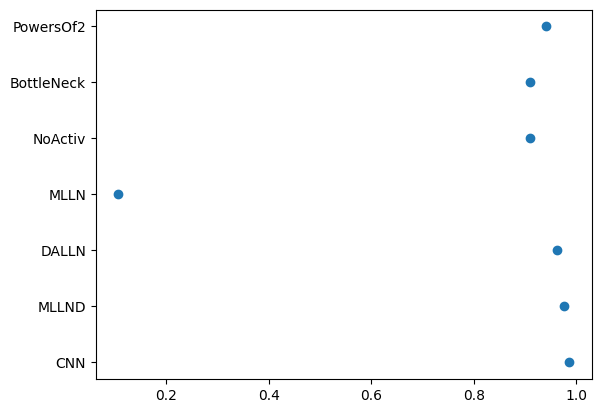

In [56]:
plt.scatter(Score.values(), Score.keys())
print(Score)

**Convolutional neural network got the best ACC, most of the time, on the test set but it also takes the longest to train**

----
Some final remarks:
* PyTorch also offers autoloading some datasets, see e.g. [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)
* Early stopping should also save the parameters of the best model and restore them upon termination. I decided to skip this part to avoid adding yet another opaque piece. If you are interested see [https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)
* As all deep learning libraries, PyTorch offers support for offloading computation to GPU. In practice the difference is tremendous, but you need a graphics card supporting CUDA, i.e., an Nvidia card. Since this is a rather restrictive requirement, I elected not to introduce this aspect. If you are interested, see e.g. [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). If you don't have an Nvidia card, there are services out there that will allow you to access one for free for a short period of time, e.g., Google Colab [https://colab.research.google.com/](https://colab.research.google.com/) or Paperspace Gradient [https://www.paperspace.com/gradient/free-gpu](https://www.paperspace.com/gradient/free-gpu).
* *Layer* is a vague term. It could be argued that neither dropout nor relu by themselves are layers, but rather they form a single layer together with `nn.Linear`. In here, I elected to follow the same naming convention that is used in the PyTorch documentation.